In [1]:
# import warnings
# warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pandas as pd
import networkx as nx
import torch

from cell import utils
from cell.utils import link_prediction_performance, edge_overlap
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# CORA ML

In [3]:
#train_graph 
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [4]:
val_share = 0.05
test_share = 0.1
seed = 42 #481516234

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [7]:
def visualize_from_adj_m(adj_m, ax=None):

    G = nx.from_scipy_sparse_matrix(adj_m)
    d = dict(nx.degree(G))

    nx.draw(G, ax=ax, nodelist=d.keys(), node_size=[v * 10 for v in d.values()])

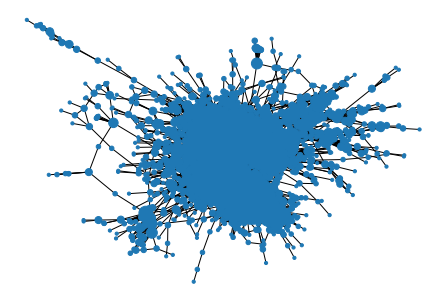

In [8]:
visualize_from_adj_m(train_graph)
plt.savefig('../img/cora_train_graph.png')

### Edge overlap

#### CELL

In [9]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='cell',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-5})

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Step:  10/200 Loss: 6.00701 Edge-Overlap: 0.041 Total-Time: 6
Step:  20/200 Loss: 4.06428 Edge-Overlap: 0.274 Total-Time: 11
Step:  30/200 Loss: 3.33609 Edge-Overlap: 0.426 Total-Time: 16
Step:  40/200 Loss: 3.01476 Edge-Overlap: 0.505 Total-Time: 22


In [10]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9421680103884549, 0.9513949926180186)

In [11]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df = pd.DataFrame(stat_df.mean(), columns=['cell'])

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


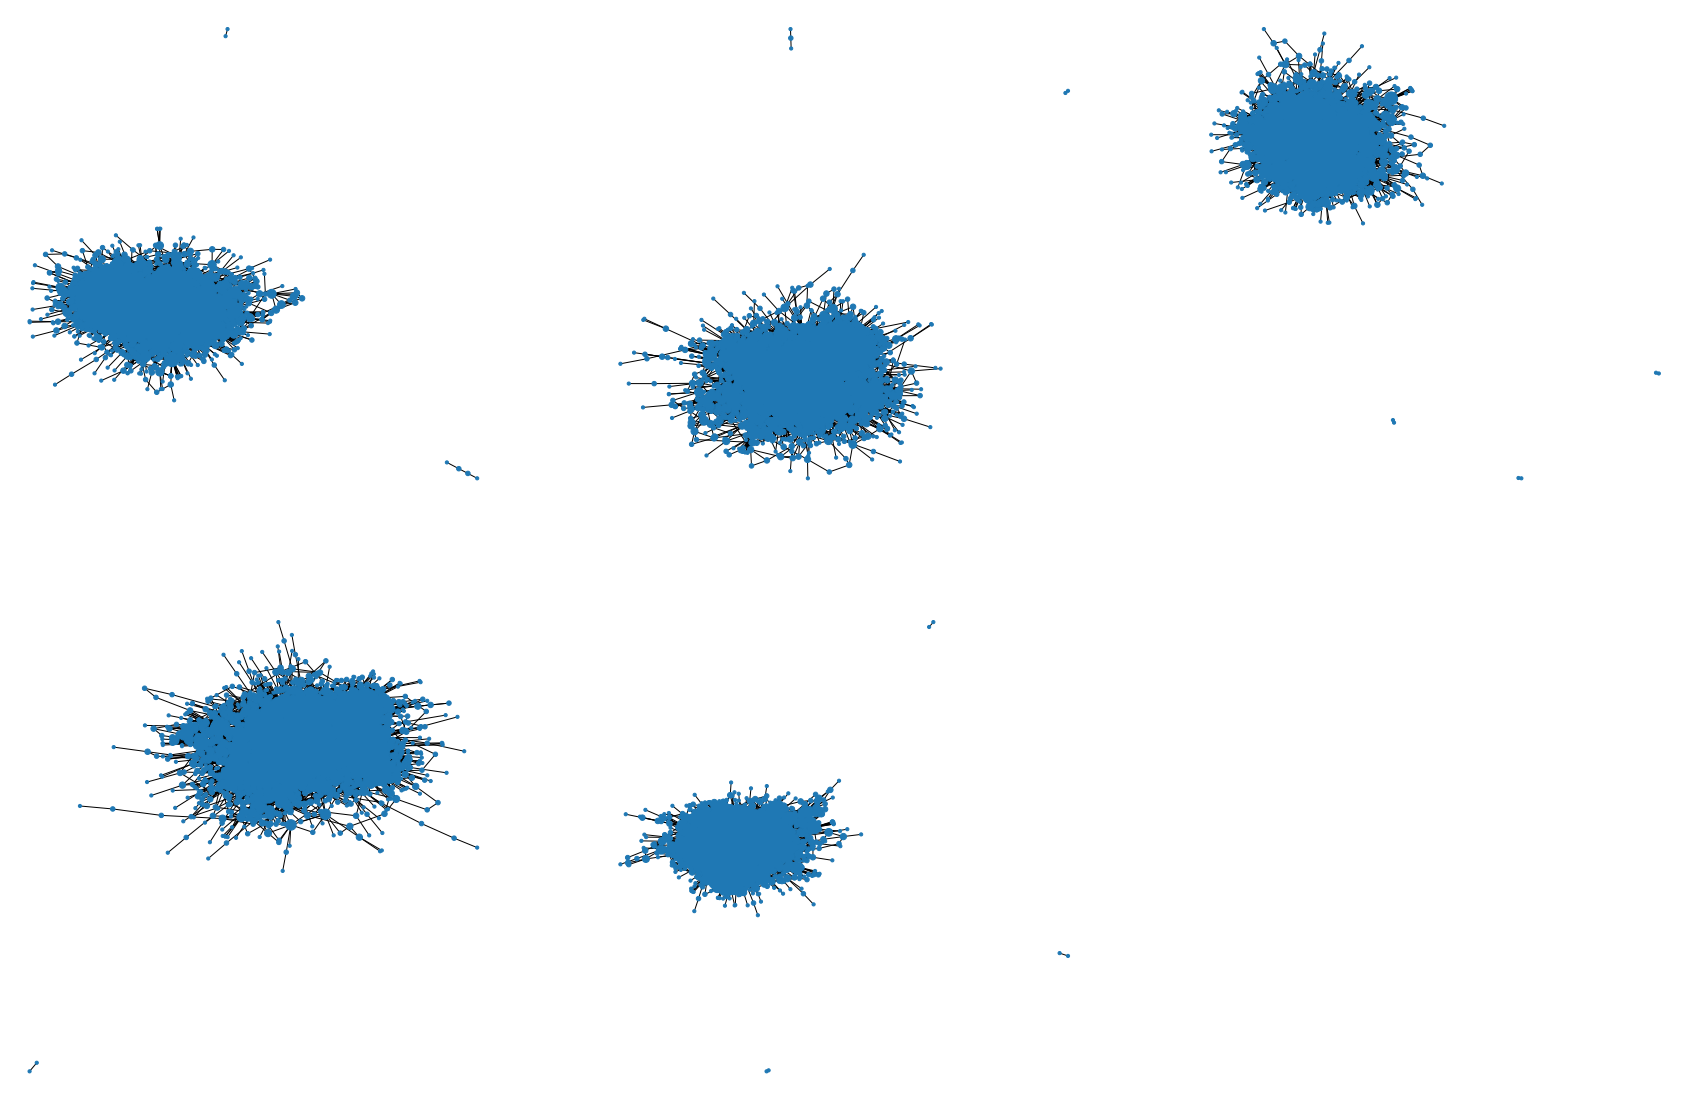

In [12]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/cora_sampled_eo_cell.png')

#### SVD

In [13]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='svd',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=400,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-5})

Step:  10/400 Loss: 7.94033 Edge-Overlap: 0.001 Total-Time: 6
Step:  20/400 Loss: 7.73881 Edge-Overlap: 0.003 Total-Time: 12
Step:  30/400 Loss: 7.14150 Edge-Overlap: 0.029 Total-Time: 18
Step:  40/400 Loss: 6.29581 Edge-Overlap: 0.082 Total-Time: 24
Step:  50/400 Loss: 5.60062 Edge-Overlap: 0.117 Total-Time: 30
Step:  60/400 Loss: 5.09365 Edge-Overlap: 0.150 Total-Time: 37
Step:  70/400 Loss: 4.71828 Edge-Overlap: 0.195 Total-Time: 44
Step:  80/400 Loss: 4.49708 Edge-Overlap: 0.206 Total-Time: 56
Step:  90/400 Loss: 4.37634 Edge-Overlap: 0.216 Total-Time: 65
Step: 100/400 Loss: 4.30338 Edge-Overlap: 0.232 Total-Time: 73
Step: 110/400 Loss: 4.24425 Edge-Overlap: 0.246 Total-Time: 79
Step: 120/400 Loss: 4.22736 Edge-Overlap: 0.257 Total-Time: 86
Step: 130/400 Loss: 4.21936 Edge-Overlap: 0.260 Total-Time: 93
Step: 140/400 Loss: 4.22765 Edge-Overlap: 0.253 Total-Time: 99
Step: 150/400 Loss: 4.22928 Edge-Overlap: 0.252 Total-Time: 105
Step: 160/400 Loss: 4.23248 Edge-Overlap: 0.266 Total-T

In [14]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9539114130460322, 0.9550896004022817)

In [15]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df['svd'] = stat_df.mean().T

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


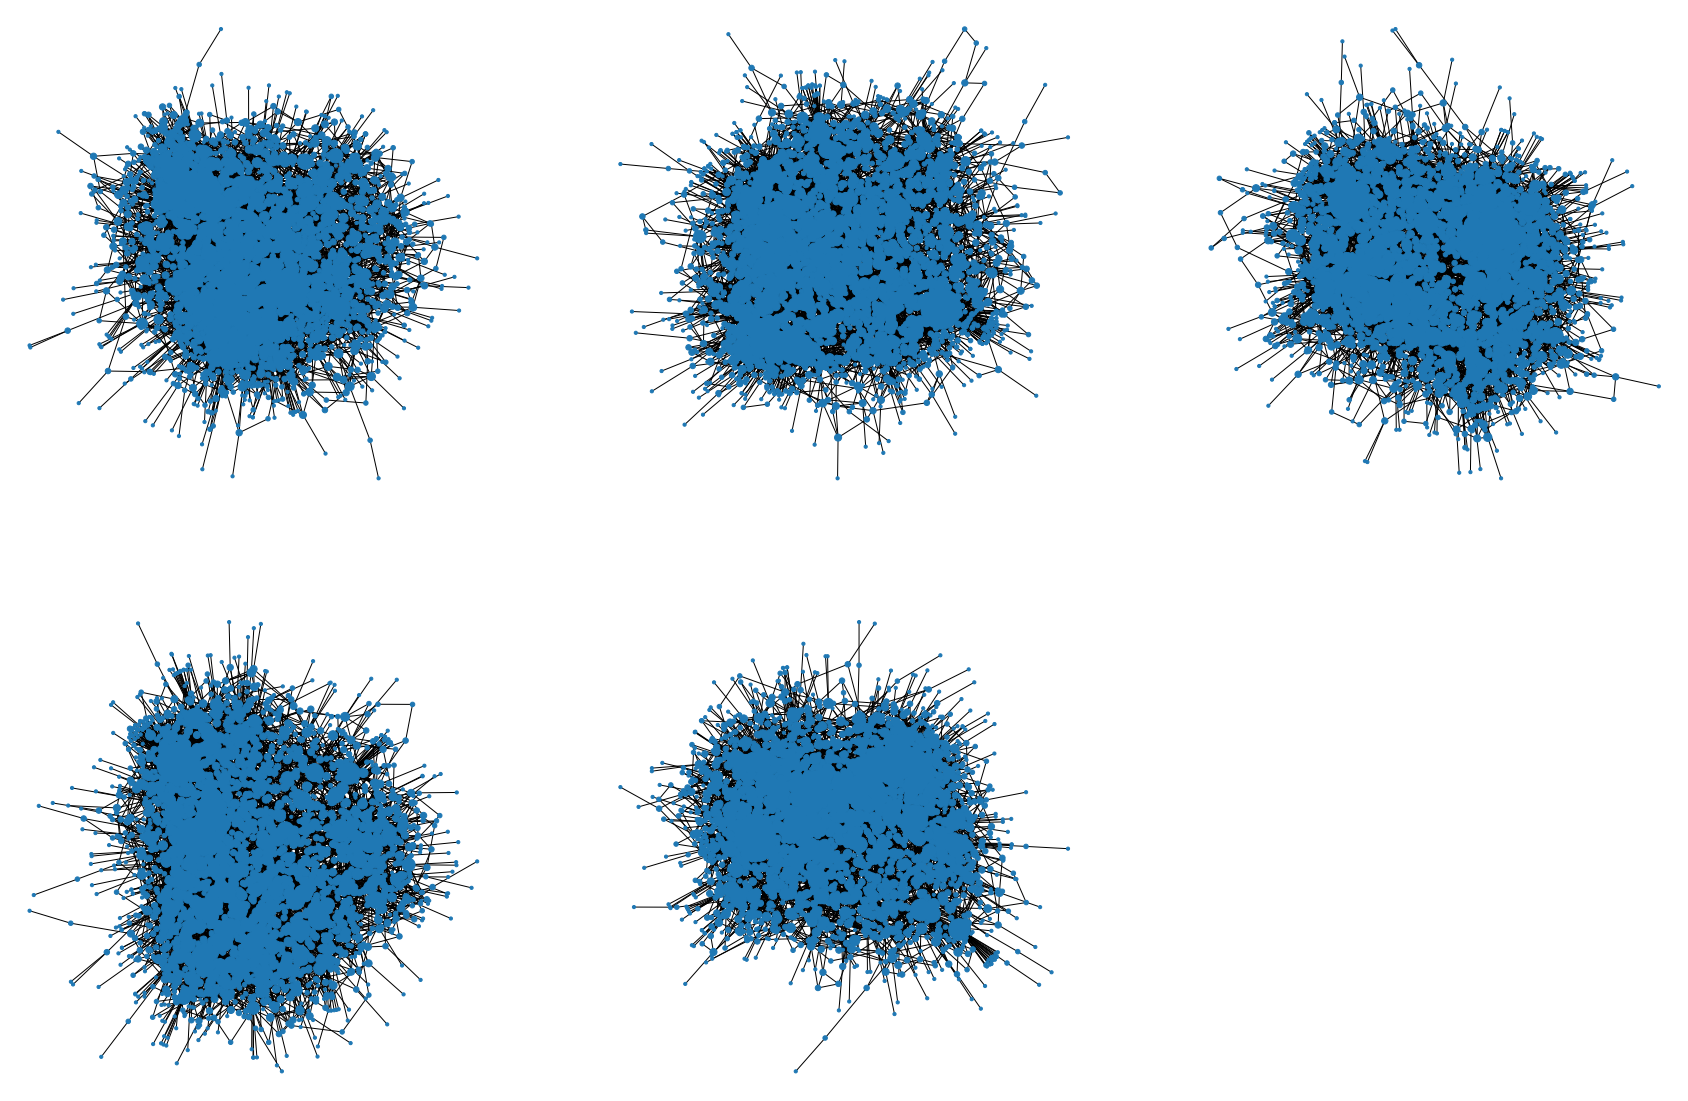

In [16]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/cora_sampled_eo_svd.png')

#### our CELL

In [17]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='fc',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-4})

/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:213: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:214: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:215: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:216: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Step:  10/200 Loss: 7.27562 Edge-Overlap: 0.021 Total-Time: 8
Step:  20/200 Loss: 7.09671 Edge-Overlap: 0.018 Total-Time: 15
Step:  30/200 Loss: 6.28837 Edge-Overlap: 0.039 Total-Time: 23
Step:  40/200 Loss: 5.51009 Edge-Overlap: 0.086 Total-Time: 30
Step:  50/200 Loss: 5.21353 Edge-Overlap: 0.105 Total-Time: 38
Step:  60/200 Loss: 4.33323 Edge-Overlap: 0.229 Total-Time: 46
Step:  70/200 Loss: 4.02211 Edge-Overlap: 0.263 Total-Time: 53
Step:  80/200 Loss: 3.63006 Edge-Overlap: 0.351 Total-Time: 61
Step:  90/200 Loss: 3.32646 Edge-Overlap: 0.420 Total-Time: 68
Step: 100/200 Loss: 3.24707 Edge-Overlap: 0.460 Total-Time: 76
Step: 110/200 Loss: 3.06242 Edge-Overlap: 0.498 Total-Time: 83
Step: 120/200 Loss: 3.04576 Edge-Overlap: 0.501 Total-Time: 90


In [18]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9538628542248522, 0.9560603890443812)

In [19]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df['cell+fc'] = stat_df.mean().T

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


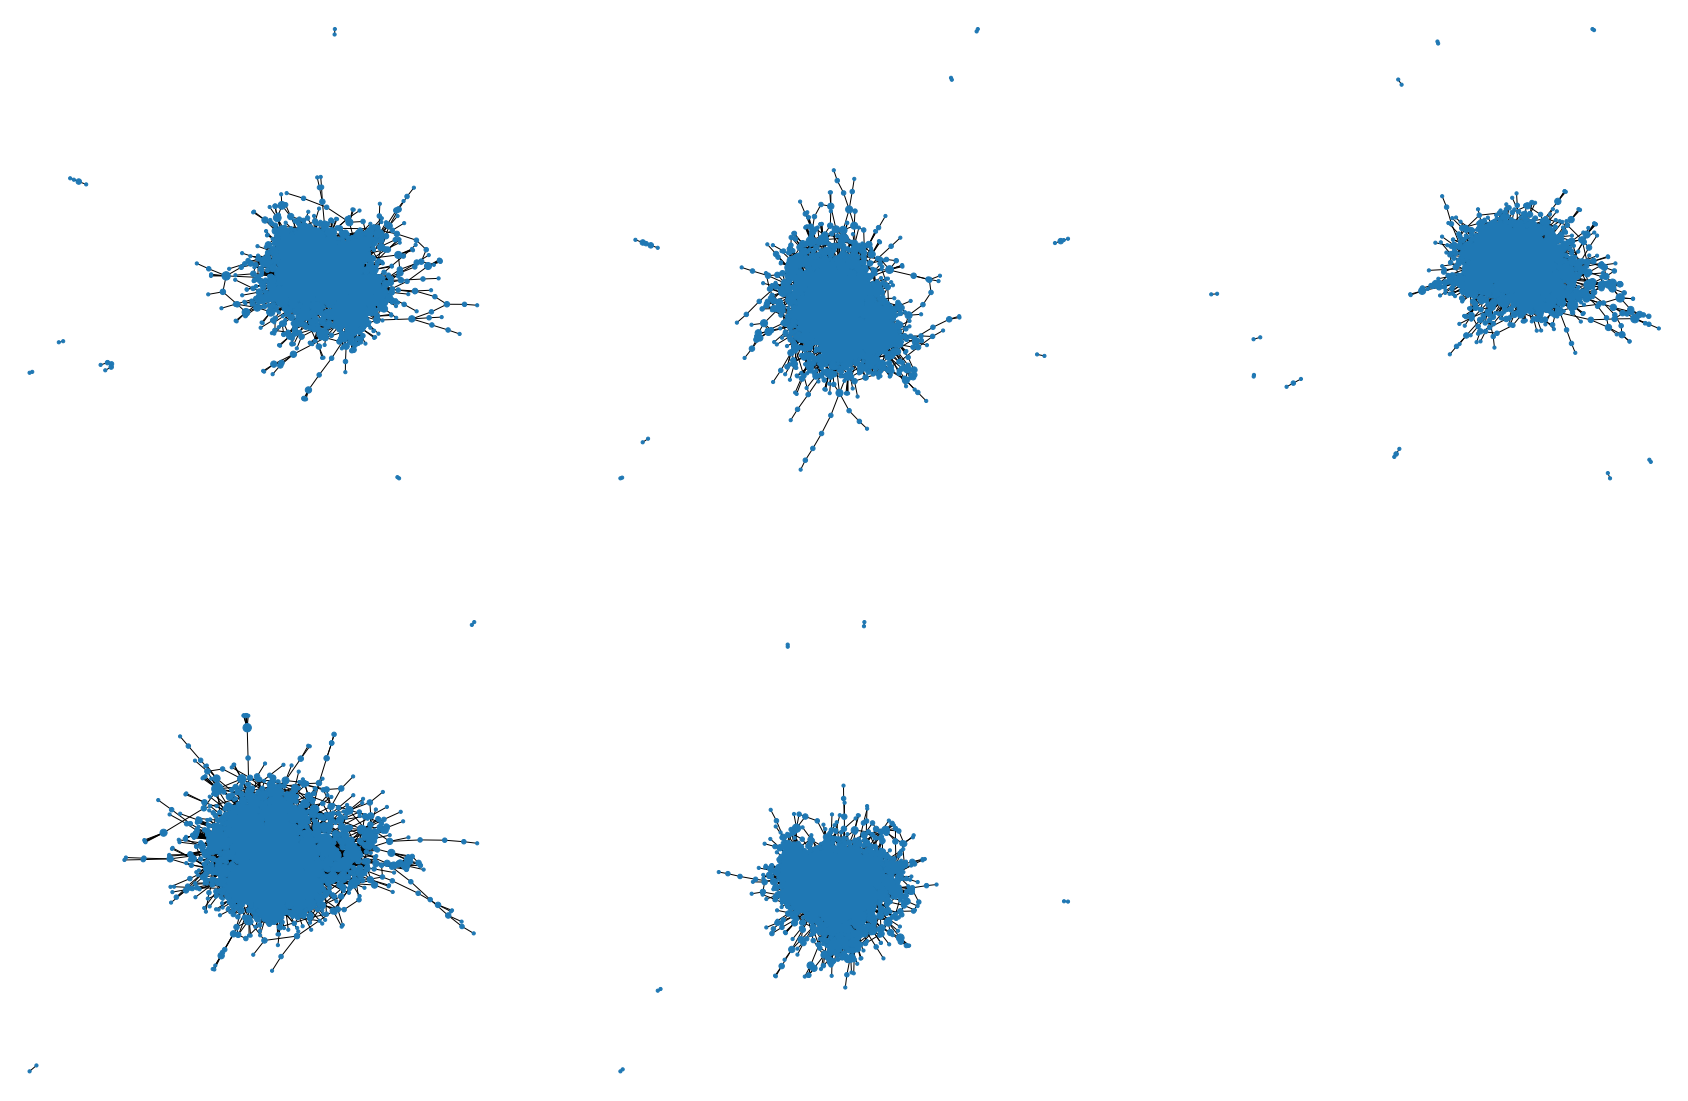

In [20]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/cora_sampled_eo_cell_fc.png')

#### Results

In [21]:
df['gt'] = compute_graph_statistics(_A_obs).values()

In [22]:
df

cell           svd        cell+fc  \
d_max                   1.994000e+02  1.684000e+02     119.400000   
d_min                   1.000000e+00  1.000000e+00       1.000000   
d                       4.827758e+00  4.827758e+00       4.827758   
LCC                     2.805000e+03  2.810000e+03    2795.600000   
wedge_count             8.039260e+04  7.749600e+04   82535.400000   
claw_count              1.836856e+06  1.312939e+06  998143.400000   
triangle_count          1.215400e+03  1.289400e+03    1852.600000   
square_count            5.820400e+03  5.405200e+03   12730.800000   
power_law_exp           1.809369e+00  1.827222e+00       1.872770   
gini                    4.394325e-01  4.563118e-01       0.496778   
rel_edge_distr_entropy  9.524116e-01  9.497944e-01       0.940652   
assortativity          -6.857334e-02 -9.608573e-02      -0.068437   
clustering_coefficient  4.543229e-02  4.991865e-02       0.067359   
cpl                     5.145413e+00  5.180306e+00       5.612216   

                                  gt  
d_max                   2.460000e+02  
d_min                   1.000000e+00  
d                       5.680427e+00  
LCC                     2.810000e+03  
wedge_count             1.377190e+05  
claw_count              3.930163e+06  
triangle_count          5.247000e+03  
square_count            3.450700e+04  
power_law_exp           1.767268e+00  
gini                    4.964733e-01  
rel_edge_distr_entropy  9.385288e-01  
assortativity          -7.659231e-02  
clustering_coefficient  1.142980e-01  
cpl                     5.271418e+00

### Link Prediction Criterion

#### CELL

In [23]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             g_type='cell',
             H=9,
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)])

# train model 
model.train(steps=300,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-6})

Step:   2/300 Loss: 7.92564 ROC-AUC Score: 0.584 Average Precision: 0.602 Total-Time: 1
Step:   4/300 Loss: 7.71820 ROC-AUC Score: 0.652 Average Precision: 0.672 Total-Time: 2
Step:   6/300 Loss: 7.29304 ROC-AUC Score: 0.701 Average Precision: 0.722 Total-Time: 3
Step:   8/300 Loss: 6.68293 ROC-AUC Score: 0.746 Average Precision: 0.767 Total-Time: 4
Step:  10/300 Loss: 6.01781 ROC-AUC Score: 0.797 Average Precision: 0.816 Total-Time: 4
Step:  12/300 Loss: 5.43345 ROC-AUC Score: 0.843 Average Precision: 0.859 Total-Time: 5
Step:  14/300 Loss: 4.99032 ROC-AUC Score: 0.872 Average Precision: 0.885 Total-Time: 6
Step:  16/300 Loss: 4.64143 ROC-AUC Score: 0.887 Average Precision: 0.899 Total-Time: 7
Step:  18/300 Loss: 4.33879 ROC-AUC Score: 0.897 Average Precision: 0.908 Total-Time: 8
Step:  20/300 Loss: 4.08583 ROC-AUC Score: 0.907 Average Precision: 0.917 Total-Time: 9
Step:  22/300 Loss: 3.87233 ROC-AUC Score: 0.918 Average Precision: 0.927 Total-Time: 10
Step:  24/300 Loss: 3.69306 ROC

In [24]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9523246360829635, 0.9562233651087592)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


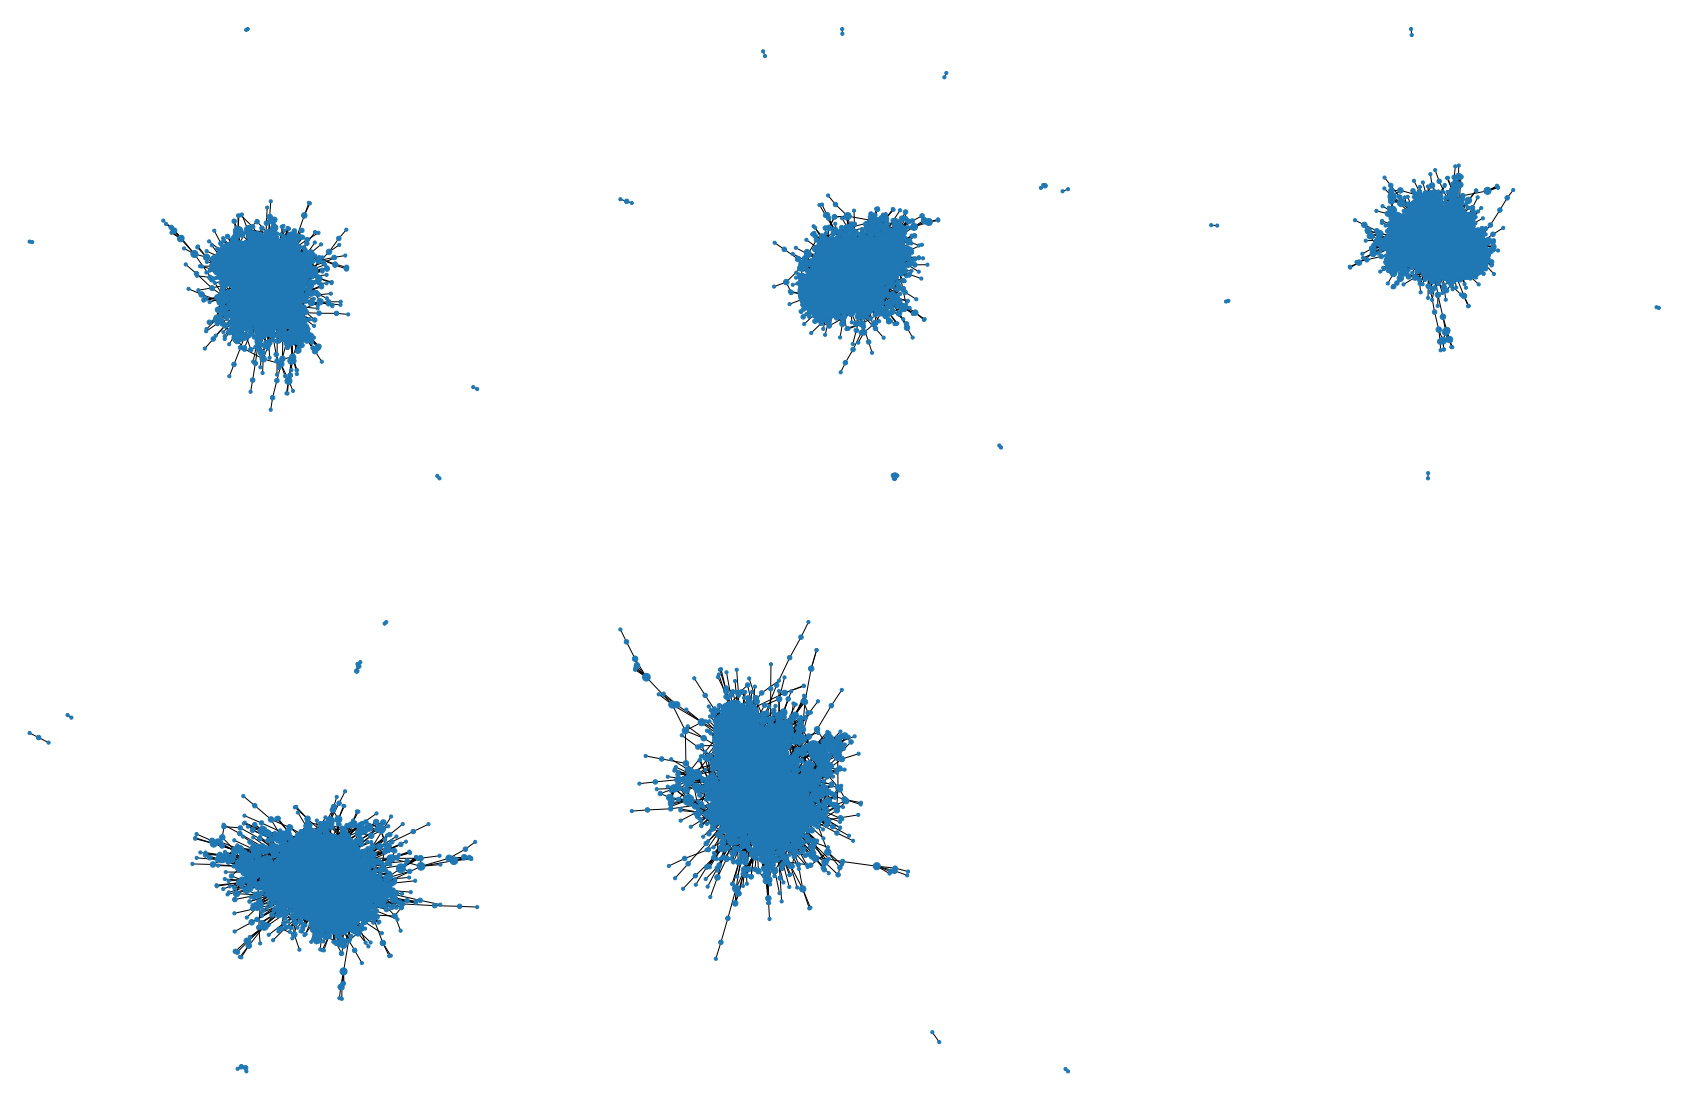

In [25]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/lp_sampled_eo_cell.png')

#### SVD

In [26]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             g_type='svd',
             H=9,
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)])

# train model 
model.train(steps=300,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-6})

Step:   2/300 Loss: 7.94371 ROC-AUC Score: 0.525 Average Precision: 0.533 Total-Time: 1
Step:   4/300 Loss: 7.94343 ROC-AUC Score: 0.527 Average Precision: 0.529 Total-Time: 2
Step:   6/300 Loss: 7.94093 ROC-AUC Score: 0.563 Average Precision: 0.652 Total-Time: 3
Step:   8/300 Loss: 7.93994 ROC-AUC Score: 0.695 Average Precision: 0.746 Total-Time: 3
Step:  10/300 Loss: 7.93404 ROC-AUC Score: 0.790 Average Precision: 0.832 Total-Time: 4
Step:  12/300 Loss: 7.91437 ROC-AUC Score: 0.847 Average Precision: 0.883 Total-Time: 5
Step:  14/300 Loss: 7.87118 ROC-AUC Score: 0.876 Average Precision: 0.899 Total-Time: 6
Step:  16/300 Loss: 7.78488 ROC-AUC Score: 0.880 Average Precision: 0.902 Total-Time: 7
Step:  18/300 Loss: 7.64687 ROC-AUC Score: 0.882 Average Precision: 0.903 Total-Time: 8
Step:  20/300 Loss: 7.49628 ROC-AUC Score: 0.896 Average Precision: 0.912 Total-Time: 9
Step:  22/300 Loss: 7.33404 ROC-AUC Score: 0.905 Average Precision: 0.917 Total-Time: 10
Step:  24/300 Loss: 7.09987 ROC

In [27]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9523309017373094, 0.9581288815823935)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


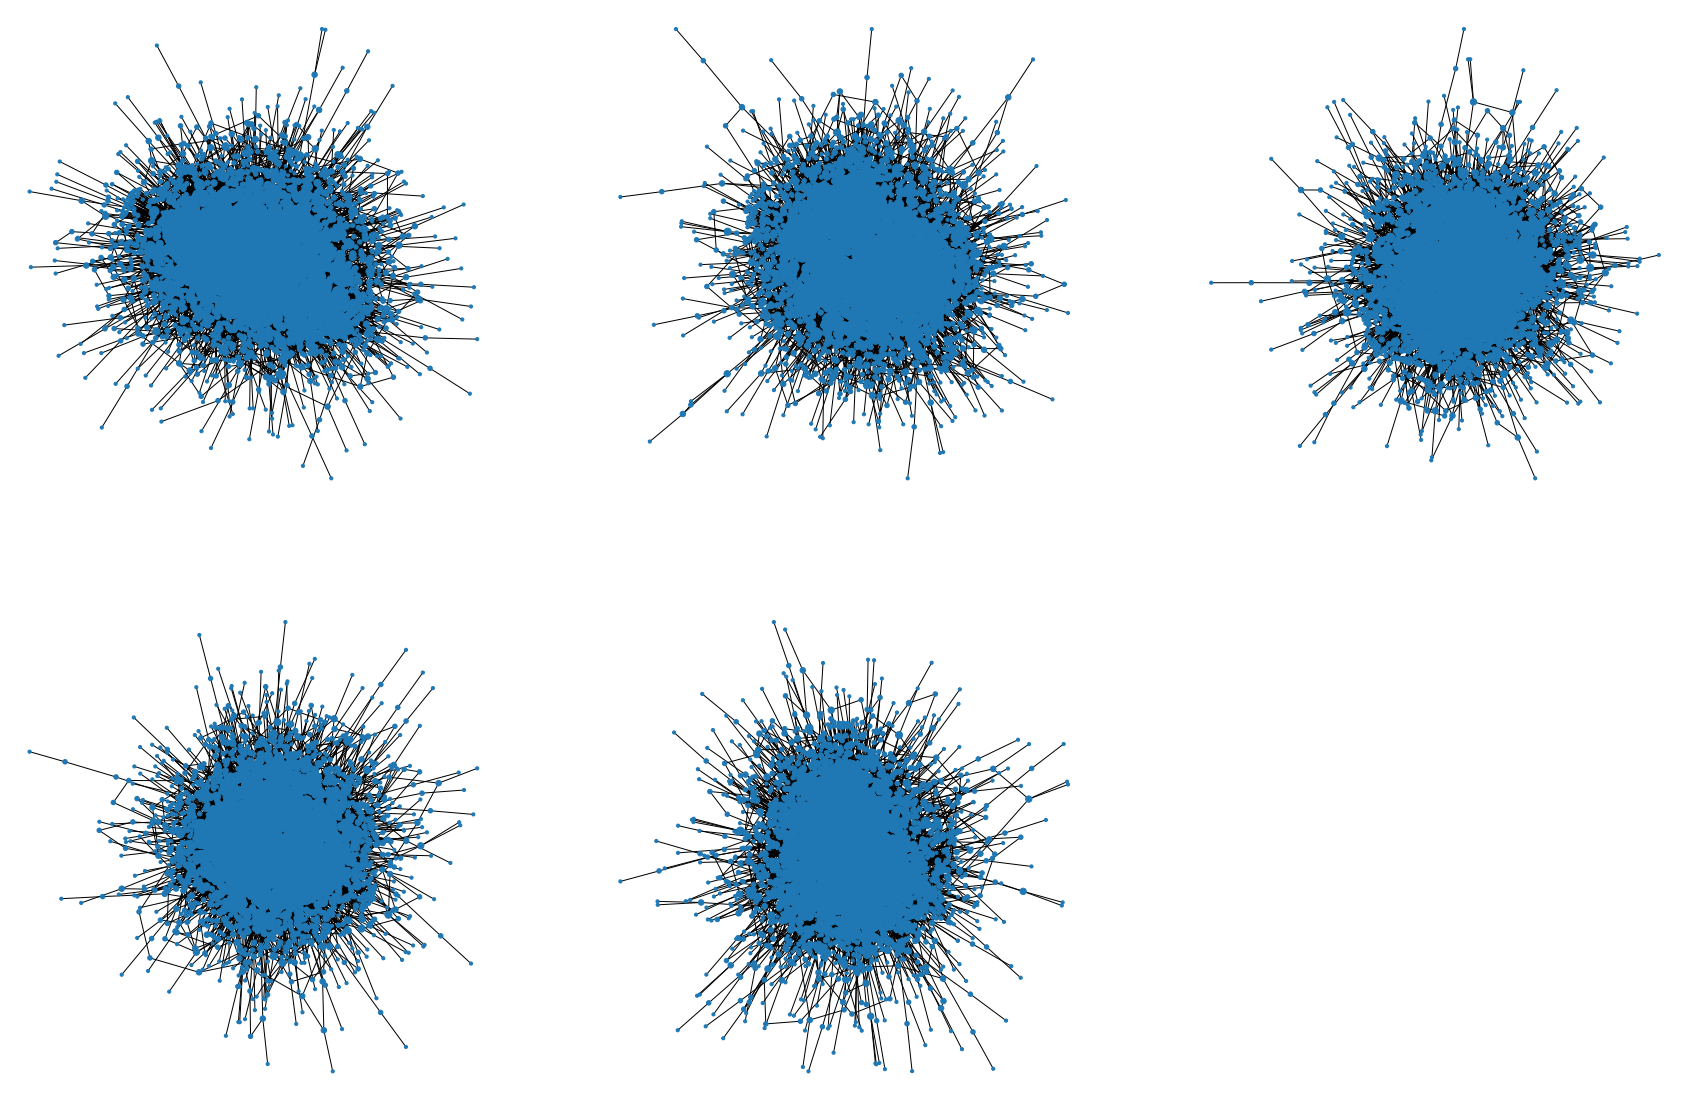

In [28]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/lp_sampled_eo_svd.png')

#### our CELL

In [29]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             g_type='fc',
             H=9,
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)])
# train model 
model.train(steps=300,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 5e-5})

/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:213: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:214: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:215: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:216: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Step:   2/300 Loss: 7.95944 ROC-AUC Score: 0.807 Average Precision: 0.827 Total-Time: 1
Step:   4/300 Loss: 7.89247 ROC-AUC Score: 0.827 Average Precision: 0.830 Total-Time: 3
Step:   6/300 Loss: 7.50187 ROC-AUC Score: 0.843 Average Precision: 0.851 Total-Time: 4
Step:   8/300 Loss: 7.31504 ROC-AUC Score: 0.853 Average Precision: 0.872 Total-Time: 6
Step:  10/300 Loss: 7.28230 ROC-AUC Score: 0.829 Average Precision: 0.850 Total-Time: 7
Step:  12/300 Loss: 7.24902 ROC-AUC Score: 0.827 Average Precision: 0.850 Total-Time: 8
Step:  14/300 Loss: 7.16588 ROC-AUC Score: 0.838 Average Precision: 0.861 Total-Time: 10
Step:  16/300 Loss: 7.01853 ROC-AUC Score: 0.849 Average Precision: 0.858 Total-Time: 11


In [30]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.8330046475491109, 0.8367802374699409)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


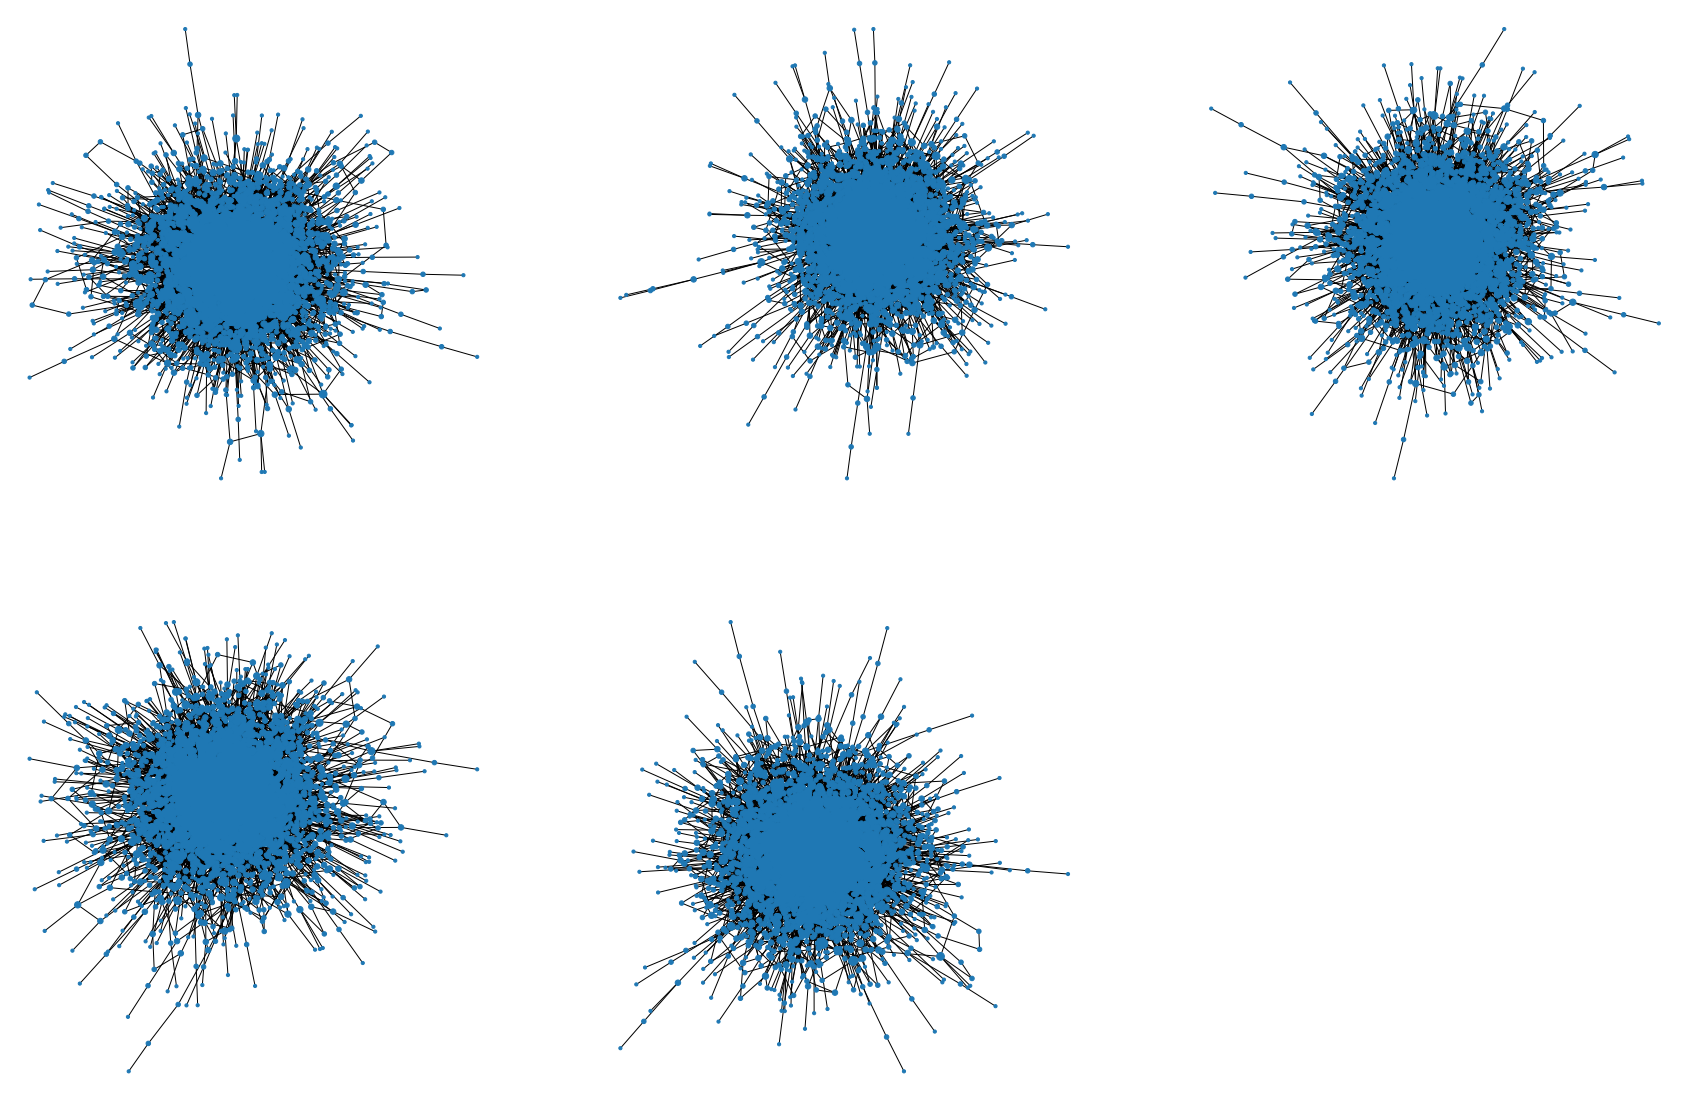

In [31]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/lp_sampled_eo_cell_fc.png')

# Citeseer

In [32]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/citeseer.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
_A_obs = _A_obs - sp.eye(_A_obs.shape[0], _A_obs.shape[0])
_A_obs[_A_obs < 0] = 0
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [33]:
val_share = 0.05
test_share = 0.1
seed = 48

In [34]:
#there are self loops!

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [35]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

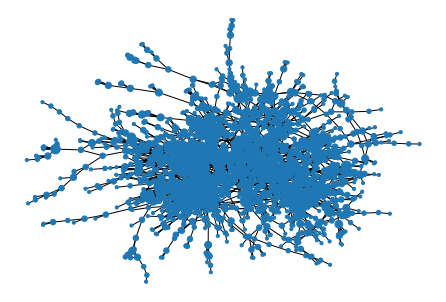

In [36]:
visualize_from_adj_m(train_graph)
plt.savefig('../img/citeseer_train_graph.png')

#### CELL

In [37]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='cell',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})

Step:  10/200 Loss: 5.24528 Edge-Overlap: 0.042 Total-Time: 3
Step:  20/200 Loss: 2.93883 Edge-Overlap: 0.345 Total-Time: 6
Step:  30/200 Loss: 2.05620 Edge-Overlap: 0.620 Total-Time: 9


In [38]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.8696685964083175, 0.8968688560327627)

In [39]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df = pd.DataFrame(stat_df.mean(), columns=['cell'])

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


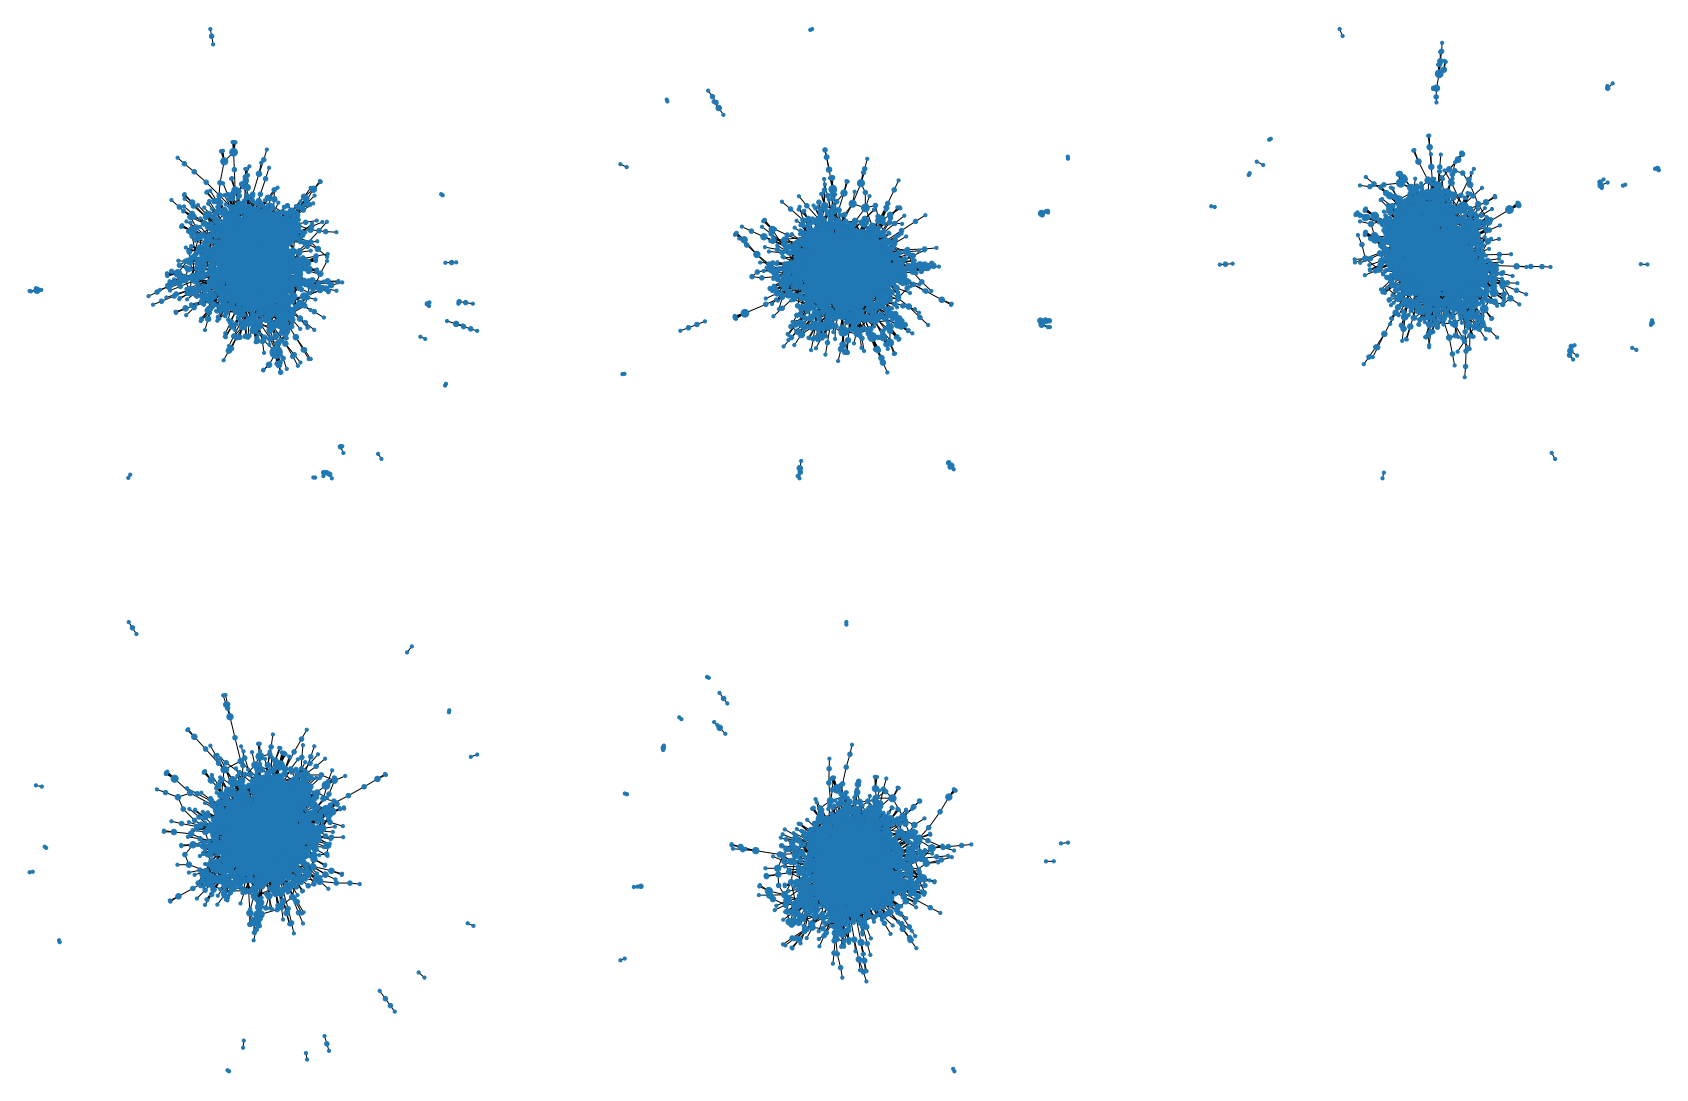

In [40]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/citeseer_sampled_eo_cell.png')

#### SVD

In [41]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='svd',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=400,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})

Step:  10/400 Loss: 7.64909 Edge-Overlap: 0.001 Total-Time: 3
Step:  20/400 Loss: 7.35609 Edge-Overlap: 0.007 Total-Time: 7
Step:  30/400 Loss: 6.39168 Edge-Overlap: 0.048 Total-Time: 10
Step:  40/400 Loss: 4.98077 Edge-Overlap: 0.125 Total-Time: 13
Step:  50/400 Loss: 3.66238 Edge-Overlap: 0.292 Total-Time: 17
Step:  60/400 Loss: 2.90394 Edge-Overlap: 0.463 Total-Time: 20
Step:  70/400 Loss: 2.45722 Edge-Overlap: 0.594 Total-Time: 23


In [42]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9143652528355387, 0.9328439004367717)

In [43]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df['svd'] = stat_df.mean().T

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


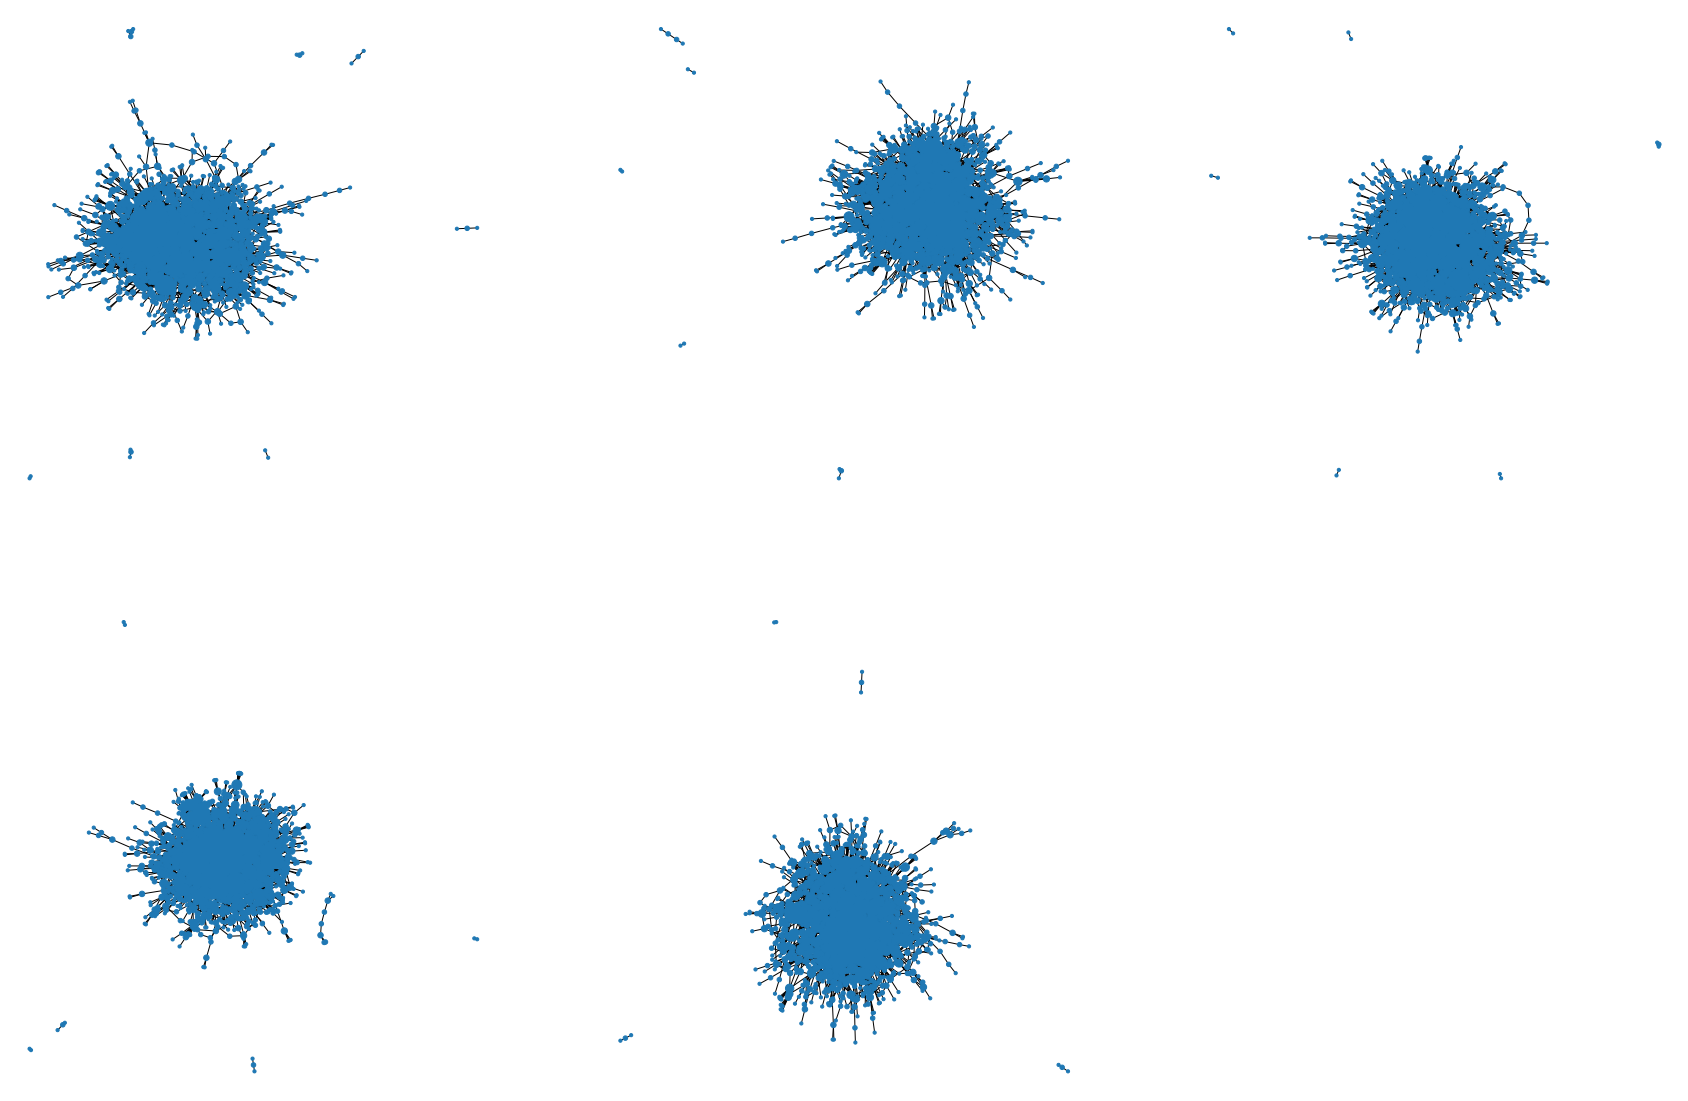

In [44]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/citeseer_sampled_eo_svd.png')

#### our CELL

In [45]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='fc',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.05,
                            'weight_decay': 1e-5})

/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:213: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:214: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:215: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:216: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Step:  10/200 Loss: 6.13664 Edge-Overlap: 0.023 Total-Time: 4
Step:  20/200 Loss: 3.74392 Edge-Overlap: 0.258 Total-Time: 8
Step:  30/200 Loss: 2.50252 Edge-Overlap: 0.515 Total-Time: 12


In [46]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.8834623109640831, 0.901631034493648)

In [47]:
generated_graphs = [model.sample_graph() for _ in range(5)]
stats = [compute_graph_statistics(gg) for gg in generated_graphs]
stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})

df['cell+fc'] = stat_df.mean().T

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/vs/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


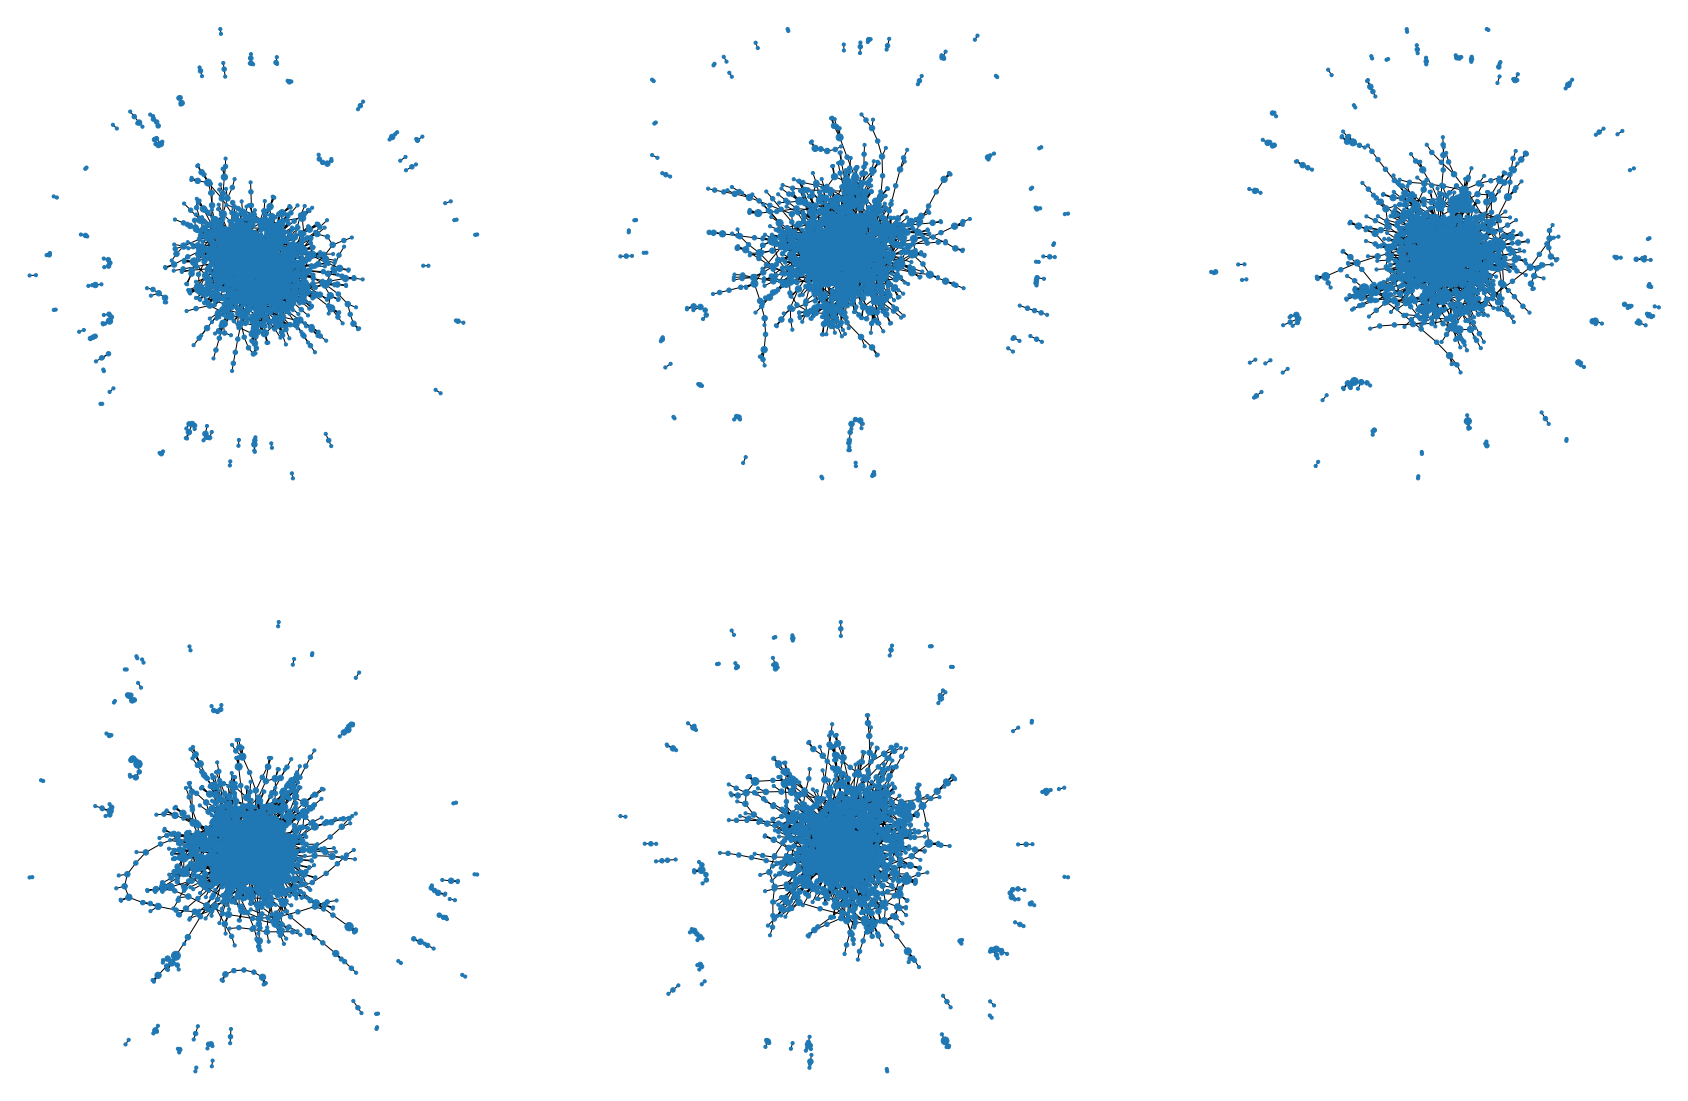

In [48]:
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/citeseer_sampled_eo_cell_fc.png')

#### Results

In [49]:
df['gt'] = compute_graph_statistics(_A_obs).values()

In [50]:
df

cell           svd        cell+fc  \
d_max                      46.400000     42.400000      85.600000   
d_min                       1.000000      1.000000       1.000000   
d                           2.954502      2.954502       2.954502   
LCC                      2068.600000   2094.600000    1943.200000   
wedge_count             12909.000000  13041.200000   21730.600000   
claw_count              45425.800000  43736.400000  192649.000000   
triangle_count            160.600000    158.200000     470.600000   
square_count              474.400000    463.000000    3402.000000   
power_law_exp               2.188458      2.195570       2.364160   
gini                        0.377524      0.381685       0.457213   
rel_edge_distr_entropy      0.966643      0.965848       0.944588   
assortativity              -0.053251     -0.081959       0.063061   
clustering_coefficient      0.037317      0.036355       0.064936   
cpl                         7.579330      7.618482       7.804549   

                                   gt  
d_max                       99.000000  
d_min                        1.000000  
d                            3.476777  
LCC                       2110.000000  
wedge_count              25943.000000  
claw_count              250348.000000  
triangle_count            1083.000000  
square_count              5977.000000  
power_law_exp                2.068238  
gini                         0.428260  
rel_edge_distr_entropy       0.953867  
assortativity                0.060227  
clustering_coefficient       0.125236  
cpl                          9.310487

In [72]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             H=9,
             g_type='cell',
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-6})

Step:   2/200 Loss: 7.63092 ROC-AUC Score: 0.633 Average Precision: 0.629 Total-Time: 0
Step:   4/200 Loss: 7.36735 ROC-AUC Score: 0.700 Average Precision: 0.711 Total-Time: 1
Step:   6/200 Loss: 6.84293 ROC-AUC Score: 0.724 Average Precision: 0.742 Total-Time: 1
Step:   8/200 Loss: 6.09010 ROC-AUC Score: 0.731 Average Precision: 0.750 Total-Time: 1
Step:  10/200 Loss: 5.26915 ROC-AUC Score: 0.753 Average Precision: 0.774 Total-Time: 2
Step:  12/200 Loss: 4.53589 ROC-AUC Score: 0.788 Average Precision: 0.807 Total-Time: 3
Step:  14/200 Loss: 3.98187 ROC-AUC Score: 0.815 Average Precision: 0.834 Total-Time: 3
Step:  16/200 Loss: 3.57328 ROC-AUC Score: 0.832 Average Precision: 0.850 Total-Time: 4
Step:  18/200 Loss: 3.22611 ROC-AUC Score: 0.840 Average Precision: 0.856 Total-Time: 4
Step:  20/200 Loss: 2.93088 ROC-AUC Score: 0.850 Average Precision: 0.864 Total-Time: 4
Step:  22/200 Loss: 2.68452 ROC-AUC Score: 0.861 Average Precision: 0.875 Total-Time: 5
Step:  24/200 Loss: 2.47382 ROC-

In [73]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.8834106214555764, 0.9093101891993639)

In [74]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             H=9,
             g_type='svd',
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-6})

Step:   2/200 Loss: 7.65593 ROC-AUC Score: 0.561 Average Precision: 0.549 Total-Time: 0
Step:   4/200 Loss: 7.65572 ROC-AUC Score: 0.525 Average Precision: 0.525 Total-Time: 0
Step:   6/200 Loss: 7.65409 ROC-AUC Score: 0.580 Average Precision: 0.652 Total-Time: 1
Step:   8/200 Loss: 7.65061 ROC-AUC Score: 0.678 Average Precision: 0.742 Total-Time: 1
Step:  10/200 Loss: 7.63631 ROC-AUC Score: 0.774 Average Precision: 0.817 Total-Time: 2
Step:  12/200 Loss: 7.59732 ROC-AUC Score: 0.814 Average Precision: 0.846 Total-Time: 2
Step:  14/200 Loss: 7.51184 ROC-AUC Score: 0.846 Average Precision: 0.865 Total-Time: 2
Step:  16/200 Loss: 7.35162 ROC-AUC Score: 0.858 Average Precision: 0.875 Total-Time: 3
Step:  18/200 Loss: 7.13328 ROC-AUC Score: 0.880 Average Precision: 0.893 Total-Time: 3
Step:  20/200 Loss: 6.92330 ROC-AUC Score: 0.892 Average Precision: 0.905 Total-Time: 4
Step:  22/200 Loss: 6.66717 ROC-AUC Score: 0.900 Average Precision: 0.912 Total-Time: 4
Step:  24/200 Loss: 6.34331 ROC-

In [75]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9213064154064272, 0.9388324968020753)

In [92]:
# initialize model with LP-criterion
#
model = Cell(A=train_graph,
             H=9,
             g_type='fc',
             callbacks=[LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-4})

Step:   2/200 Loss: 7.65439 ROC-AUC Score: 0.780 Average Precision: 0.795 Total-Time: 0
Step:   4/200 Loss: 7.36029 ROC-AUC Score: 0.815 Average Precision: 0.836 Total-Time: 0
Step:   6/200 Loss: 7.10053 ROC-AUC Score: 0.815 Average Precision: 0.841 Total-Time: 1
Step:   8/200 Loss: 6.99184 ROC-AUC Score: 0.807 Average Precision: 0.838 Total-Time: 1
Step:  10/200 Loss: 7.10693 ROC-AUC Score: 0.816 Average Precision: 0.844 Total-Time: 2
Step:  12/200 Loss: 6.86898 ROC-AUC Score: 0.814 Average Precision: 0.841 Total-Time: 2
Step:  14/200 Loss: 6.61680 ROC-AUC Score: 0.805 Average Precision: 0.837 Total-Time: 3
Step:  16/200 Loss: 6.33157 ROC-AUC Score: 0.814 Average Precision: 0.846 Total-Time: 3
Step:  18/200 Loss: 5.93422 ROC-AUC Score: 0.810 Average Precision: 0.846 Total-Time: 4
Step:  20/200 Loss: 5.55091 ROC-AUC Score: 0.789 Average Precision: 0.815 Total-Time: 4
Step:  22/200 Loss: 5.68030 ROC-AUC Score: 0.835 Average Precision: 0.853 Total-Time: 5
Step:  24/200 Loss: 5.16519 ROC-

In [93]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9035178402646502, 0.9137068964808797)

# Prolblogs

In [51]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/polblogs.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
_A_obs = _A_obs - sp.eye(_A_obs.shape[0], _A_obs.shape[0])
_A_obs[_A_obs < 0] = 0
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [52]:
val_share = 0.05
test_share = 0.1
seed = 48

In [53]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [54]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

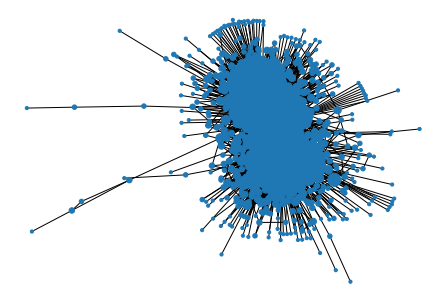

In [55]:
visualize_from_adj_m(train_graph)
plt.savefig('../img/prolblogs_train_graph.png')

#### CELL

In [56]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='cell',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Step:  10/200 Loss: 5.82327 Edge-Overlap: 0.290 Total-Time: 1
Step:  20/200 Loss: 5.48478 Edge-Overlap: 0.294 Total-Time: 3
Step:  30/200 Loss: 5.31299 Edge-Overlap: 0.329 Total-Time: 4
Step:  40/200 Loss: 5.22339 Edge-Overlap: 0.343 Total-Time: 5
Step:  50/200 Loss: 5.17130 Edge-Overlap: 0.353 Total-Time: 7
Step:  60/200 Loss: 5.13763 Edge-Overlap: 0.365 Total-Time: 8
Step:  70/200 Loss: 5.11476 Edge-Overlap: 0.372 Total-Time: 10
Step:  80/200 Loss: 5.09836 Edge-Overlap: 0.378 Total-Time: 11
Step:  90/200 Loss: 5.08593 Edge-Overlap: 0.376 Total-Time: 13
Step: 100/200 Loss: 5.07605 Edge-Overlap: 0.379 Total-Time: 14
Step: 110/200 Loss: 5.06794 Edge-Overlap: 0.386 Total-Time: 16
Step: 120/200 Loss: 5.06115 Edge-Overlap: 0.383 Total-Time: 17
Step: 130/200 Loss: 5.05533 Edge-Overlap: 0.382 Total-Time: 19
Step: 140/200 Loss: 5.05035 Edge-Overlap: 0.385 Total-Time: 21
Step: 150/200 Loss: 5.04598 Edge-Overlap: 0.393 Total-Time: 22
Step: 160/200 Loss: 5.04214 Edge-Overlap: 0.390 Total-Time: 2

In [57]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9588985644151745, 0.9585081224930698)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


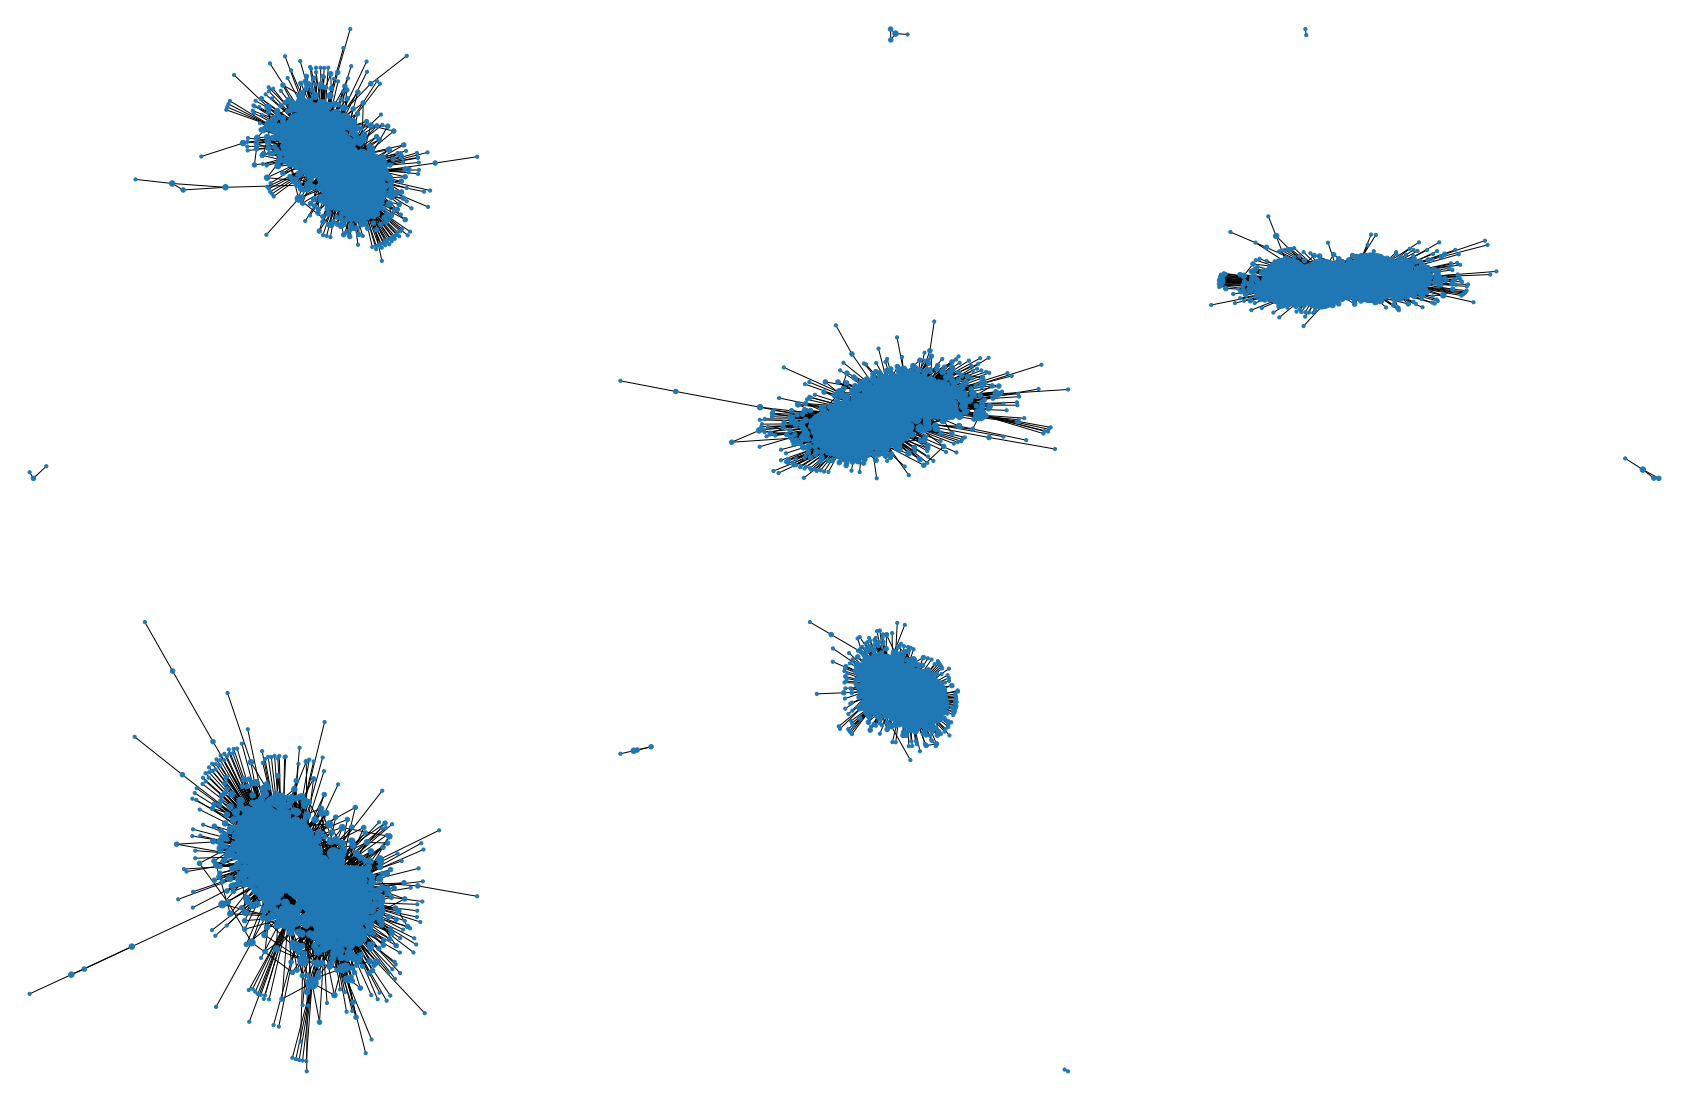

In [58]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/prolblogs_sampled_eo_cell.png')

#### SVD

In [59]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='svd',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=400,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})

Step:  10/400 Loss: 7.05938 Edge-Overlap: 0.023 Total-Time: 1
Step:  20/400 Loss: 6.32481 Edge-Overlap: 0.156 Total-Time: 3
Step:  30/400 Loss: 5.75180 Edge-Overlap: 0.272 Total-Time: 4
Step:  40/400 Loss: 5.46286 Edge-Overlap: 0.318 Total-Time: 6
Step:  50/400 Loss: 5.33176 Edge-Overlap: 0.345 Total-Time: 7
Step:  60/400 Loss: 5.28568 Edge-Overlap: 0.343 Total-Time: 9
Step:  70/400 Loss: 5.24579 Edge-Overlap: 0.355 Total-Time: 10
Step:  80/400 Loss: 5.24871 Edge-Overlap: 0.363 Total-Time: 12
Step:  90/400 Loss: 5.21844 Edge-Overlap: 0.359 Total-Time: 13
Step: 100/400 Loss: 5.20647 Edge-Overlap: 0.365 Total-Time: 15
Step: 110/400 Loss: 5.23513 Edge-Overlap: 0.360 Total-Time: 16
Step: 120/400 Loss: 5.19952 Edge-Overlap: 0.369 Total-Time: 18
Step: 130/400 Loss: 5.18816 Edge-Overlap: 0.356 Total-Time: 19
Step: 140/400 Loss: 5.19470 Edge-Overlap: 0.367 Total-Time: 21
Step: 150/400 Loss: 5.18055 Edge-Overlap: 0.369 Total-Time: 22
Step: 160/400 Loss: 5.17737 Edge-Overlap: 0.364 Total-Time: 2

In [60]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.959188318103103, 0.9597083629224615)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


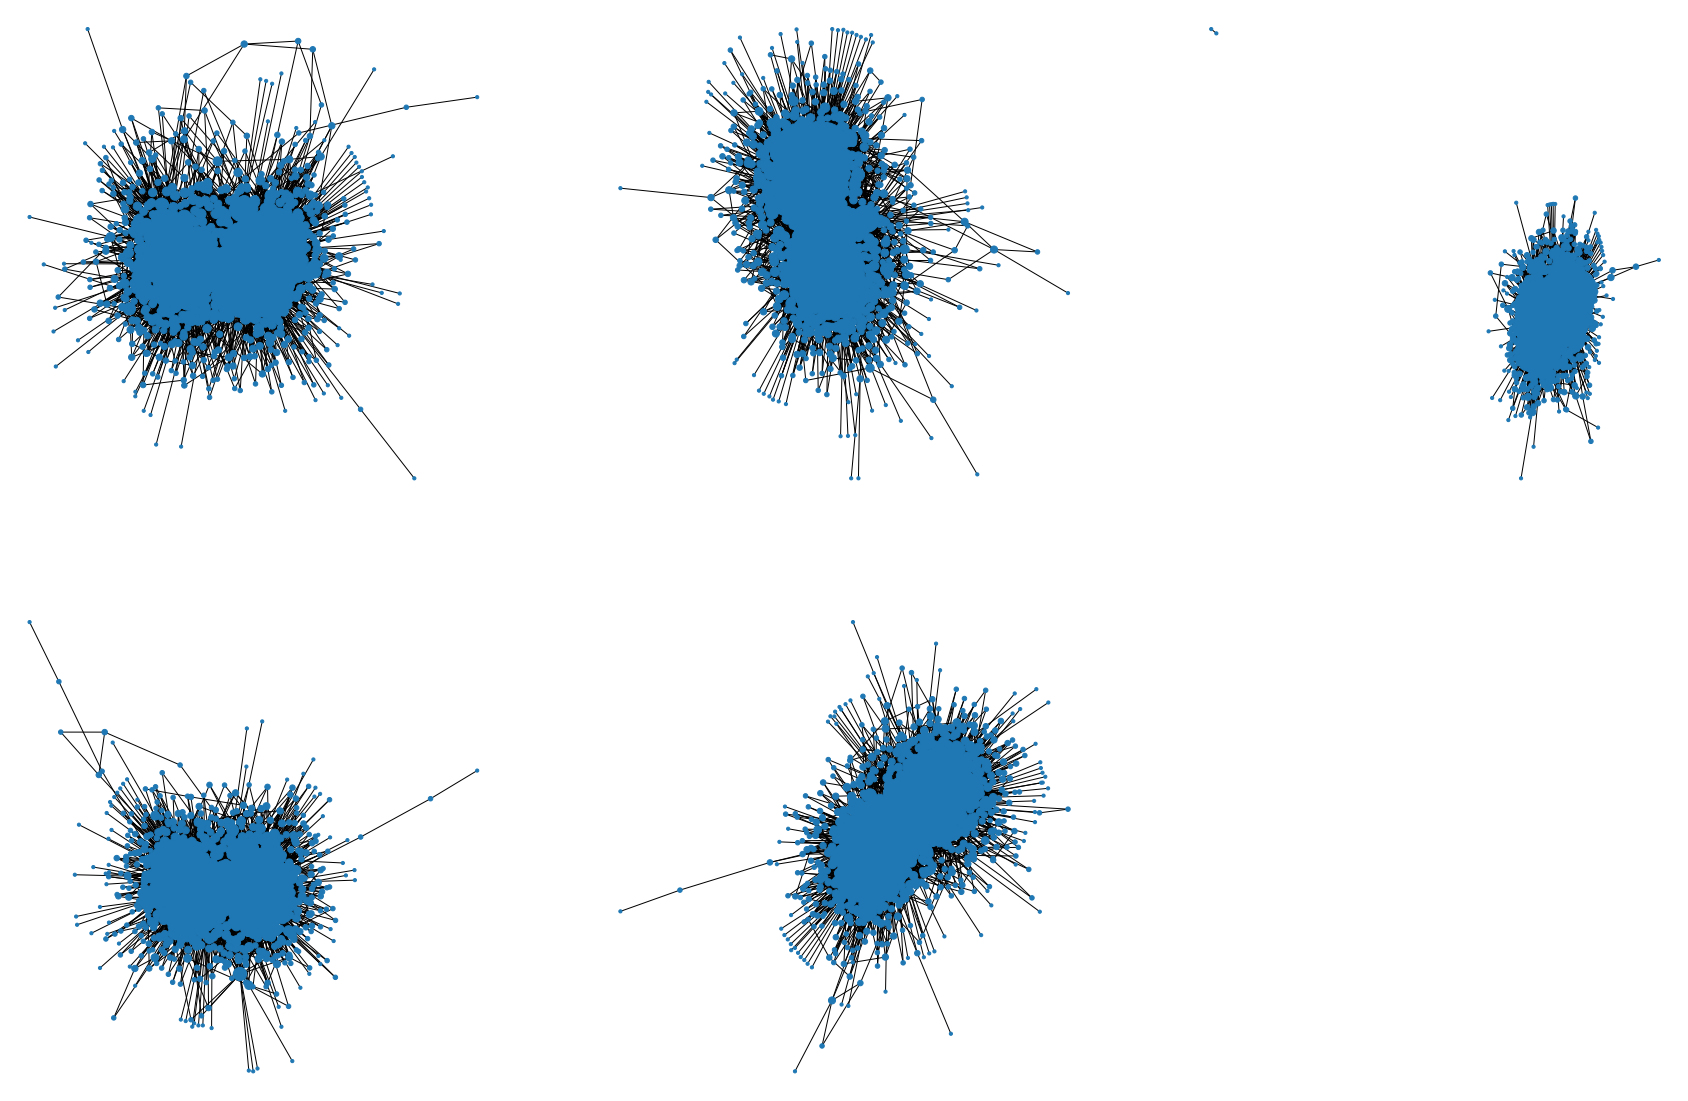

In [61]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/prolblogs_sampled_eo_svd.png')

#### our CELL

In [62]:
# initialize model with EO-criterion
model = Cell(A=train_graph,
             H=9,
             g_type='fc',
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])

# train model 
model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-5})

/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:213: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:214: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:215: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/vs/anaconda3/lib/python3.7/site-packages/netgan_without_gan-0.1-py3.7.egg/cell/cell.py:216: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Step:  10/200 Loss: 6.35562 Edge-Overlap: 0.110 Total-Time: 1
Step:  20/200 Loss: 5.90414 Edge-Overlap: 0.197 Total-Time: 3
Step:  30/200 Loss: 5.77662 Edge-Overlap: 0.227 Total-Time: 5
Step:  40/200 Loss: 5.67952 Edge-Overlap: 0.235 Total-Time: 7
Step:  50/200 Loss: 5.61042 Edge-Overlap: 0.252 Total-Time: 8
Step:  60/200 Loss: 5.54906 Edge-Overlap: 0.265 Total-Time: 10
Step:  70/200 Loss: 5.50156 Edge-Overlap: 0.285 Total-Time: 12
Step:  80/200 Loss: 5.45239 Edge-Overlap: 0.285 Total-Time: 13
Step:  90/200 Loss: 5.43276 Edge-Overlap: 0.269 Total-Time: 15
Step: 100/200 Loss: 5.38303 Edge-Overlap: 0.313 Total-Time: 17
Step: 110/200 Loss: 5.33970 Edge-Overlap: 0.317 Total-Time: 19
Step: 120/200 Loss: 5.31880 Edge-Overlap: 0.317 Total-Time: 20
Step: 130/200 Loss: 5.27392 Edge-Overlap: 0.334 Total-Time: 22
Step: 140/200 Loss: 5.29928 Edge-Overlap: 0.341 Total-Time: 24
Step: 150/200 Loss: 5.23855 Edge-Overlap: 0.345 Total-Time: 25
Step: 160/200 Loss: 5.25060 Edge-Overlap: 0.334 Total-Time: 

In [63]:
# roc-auc, avg-precision

link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)

(0.9617528704729559, 0.9627005020208268)

/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/vs/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


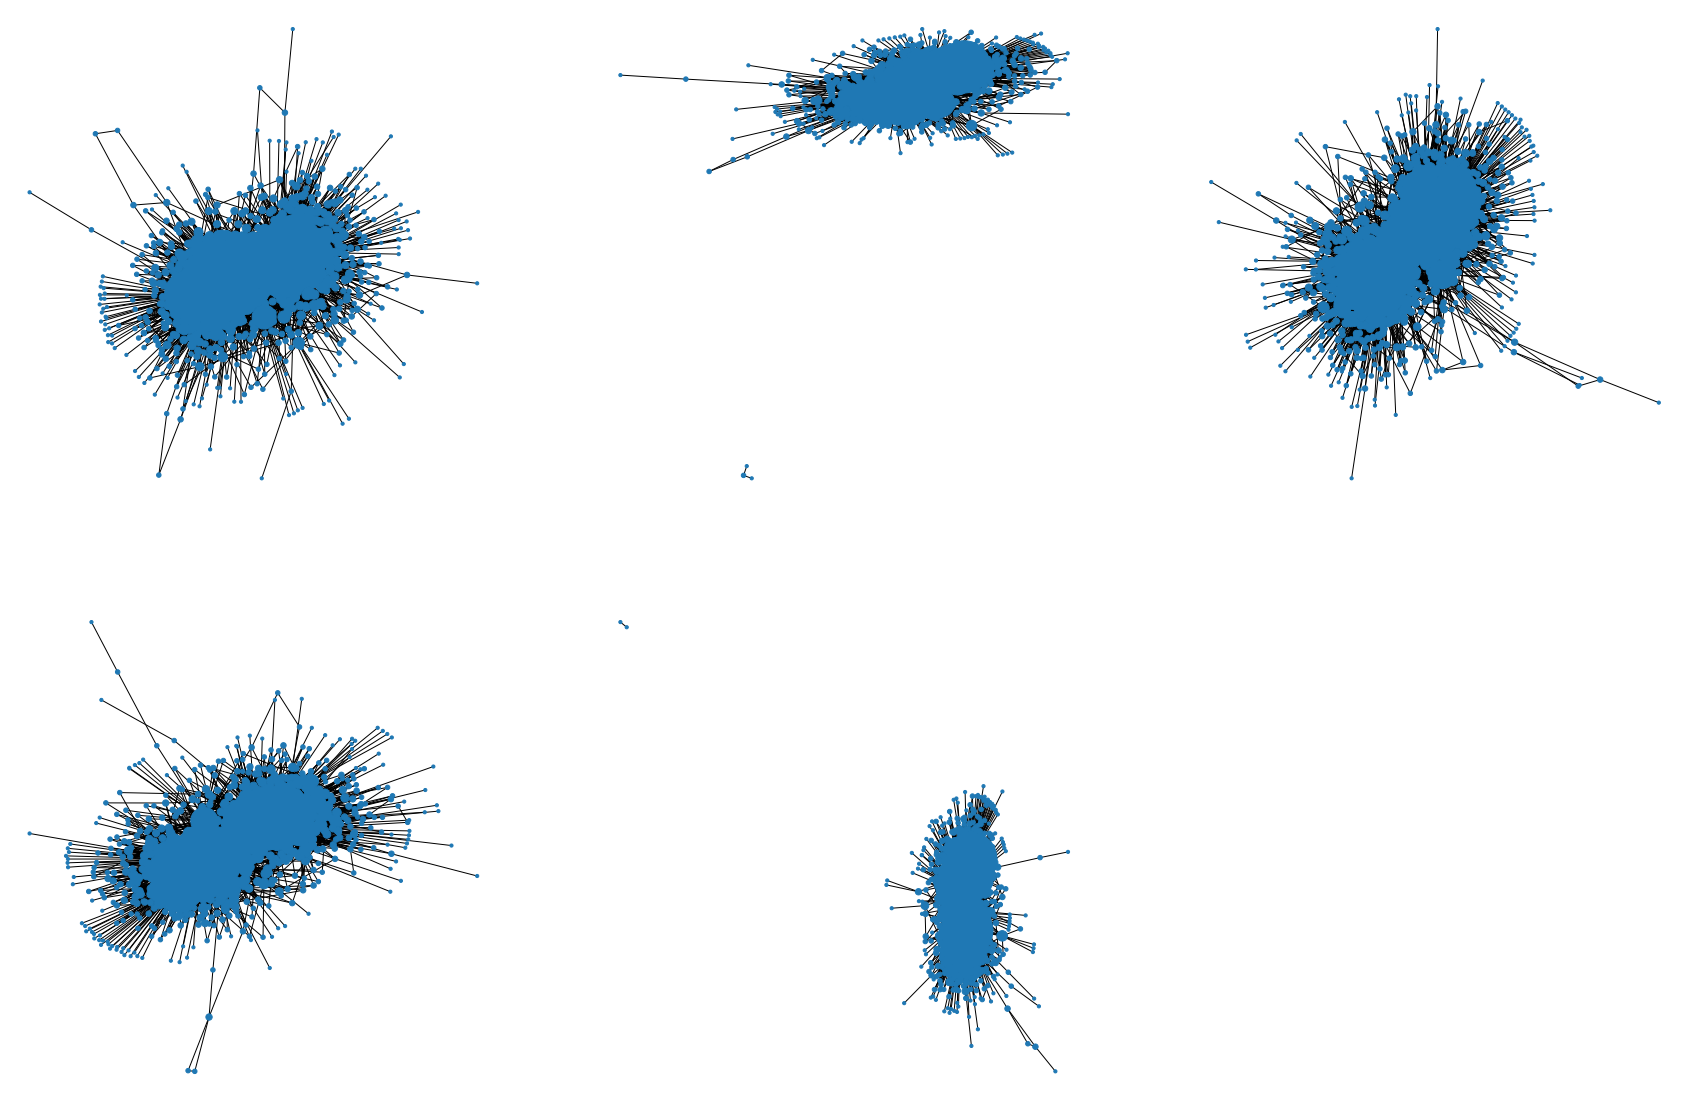

In [64]:
generated_graphs = [model.sample_graph() for _ in range(5)]
plt.figure(figsize=(30, 20))
for i in range(5):
    g = generated_graphs[i]
    ax=plt.subplot(int(f'23{i+1}'))
    visualize_from_adj_m(g, ax=ax)
plt.savefig('../img/prolblogs_sampled_eo_cell_fc.png')